In [28]:
import os
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from transformers import CLIPProcessor, CLIPModel

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [18]:
%cd D:\\Images\\Covid
%pwd

D:\Images\Covid


'D:\\Images\\Covid'

In [19]:
image_folder = 'output_images_detected'
output_folder = 'cluster_output'

In [30]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Get list of image files
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

Processing images: 100%|██████████| 14438/14438 [12:01<00:00, 20.01it/s]


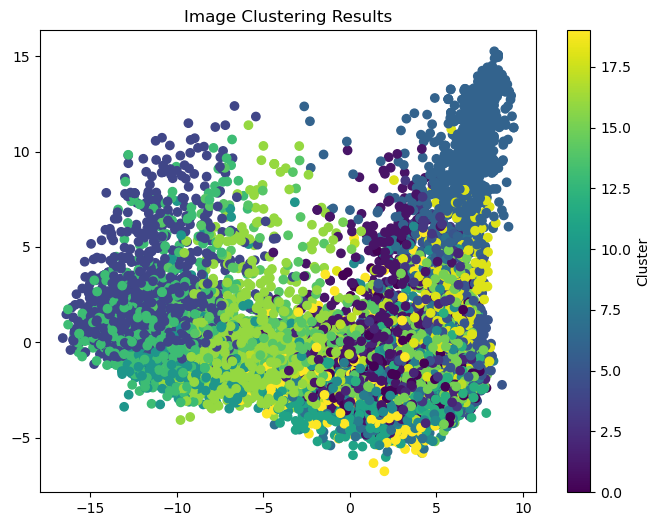

Clustering complete. Images saved to: cluster_output


In [33]:
# Function to extract image embeddings
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        return image_features.squeeze().numpy()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Extract embeddings
embeddings = []
valid_image_files = []

for image_file in tqdm(image_files, desc="Processing images"):
    image_path = os.path.join(image_folder, image_file)
    embedding = get_image_embedding(image_path)
    if embedding is not None:
        embeddings.append(embedding)
        valid_image_files.append(image_file)

# Ensure we have embeddings
if not embeddings:
    print("No valid embeddings found. Exiting.")
    exit()

# Convert to numpy array and scale
embeddings = np.array(embeddings)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Clustering with KMeans
num_clusters = 20  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings_scaled)

# Create output folders and save images
os.makedirs(output_folder, exist_ok=True)
for i in range(num_clusters):
    cluster_folder = os.path.join(output_folder, f"cluster_{i}")
    os.makedirs(cluster_folder, exist_ok=True)

# Copy images to respective cluster folders
for idx, label in enumerate(labels):
    src_path = os.path.join(image_folder, valid_image_files[idx])
    dst_path = os.path.join(output_folder, f"cluster_{label}", valid_image_files[idx])
    shutil.copy(src_path, dst_path)

# Visualize the clusters with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', marker='o')
plt.colorbar(label='Cluster')
plt.title("Image Clustering Results")
plt.show()

print("Clustering complete. Images saved to:", output_folder)


In [25]:
def get_face_embeddings(image_path):
    try:
        # Try using a different model like 'Facenet' or 'DeepFace'
        embeddings = DeepFace.represent(image_path, model_name='Facenet', enforce_detection=False)
        if embeddings:
            return embeddings[0]['embedding']
        else:
            return None
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None
